In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

  0%|          | 0/48000 [00:00<?, ?it/s]

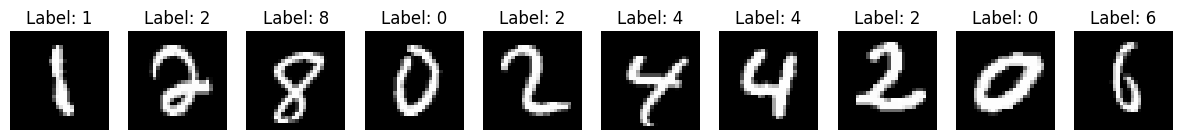

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [8]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])


train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [27]:
H_DIM = 256
Z_DIM = 32
class VAE(nn.Module):
    def __init__(self, c=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, c, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(c, c*2, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(c*2, c*4, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(c*4, c*8, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(c*8, H_DIM, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        self.mu = nn.Linear(H_DIM, Z_DIM)
        self.logVar = nn.Linear(H_DIM, Z_DIM)
        self.z2h = nn.Linear(Z_DIM, H_DIM)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (H_DIM, 1, 1)),

            nn.ConvTranspose2d(H_DIM, 512, 3, 1),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, 3, 3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 2, 1),
            nn.ReLU(),

            nn.Conv2d(64, 1, 3, 1, 1),
        )

    def encode(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        h = self.encoder(x)
        mu = self.mu(h)
        logVar = self.logVar(h)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):

        h = self.z2h(z)
        out = self.decoder(h)
        return out

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        out = self.decode(z)
        return out, mu, logVar

model = VAE().to(device)
x = torch.randn(1, 1, 28, 28).to(device)
model(x)[0].shape
# model.encoder(x).shape

torch.Size([1, 1, 28, 28])

In [28]:
def loss_fn(recon_x, x, mu, log_var):
    recon_loss = F.binary_cross_entropy_with_logits(recon_x, x, reduction="sum")
    mse = F.mse_loss(F.sigmoid(recon_x), x)
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (recon_loss + 1.0*kld), mse

def train(
        model,
        train_set,
        val_set,
        optimizer,
        n_epochs,
        batch_size,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    train_mses = []
    val_losses = []
    val_mses = []

    scaler = torch.cuda.amp.GradScaler()
    # scaler = None

    for epoch in range(n_epochs):
        train_set.apply_transform()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        train_mse = 0 
        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], train_mse=train_mses[-1], val_mse=val_mses[-1])

            optimizer.zero_grad(set_to_none=True)
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    decoded, mu, log_var = model(x)
                    loss, mse = loss_fn(decoded, x, mu, log_var)
                # loss /= len(x)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                decoded, mu, log_var = model(x)
                loss, mse = loss_fn(decoded, x, mu, log_var)
                # loss /= len(x)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()
            train_mse += mse.item()
        
        print(f'Epoch {epoch}: last_loss: {loss.item()}')
        train_losses.append(train_loss / len(train_set))
        train_mses.append(train_mse / len(train_set))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_mse = 0
            for x, _ in val_loader:
                decoded, mu, log_var = model(x)

                loss, mse = loss_fn(decoded, x, mu, log_var)
                # loss /= len(x)
                val_loss += loss.item()
                val_mse += mse.item()

            val_losses.append(val_loss / len(val_set))
            val_mses.append(val_mse / len(val_set))
        
    return train_losses, val_losses, train_mses, val_mses

In [29]:
model = VAE().to(device)
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
EPOCHS = 10
BATCH_SIZE = 128

train_losses, val_losses, train_mses, val_mses = train(model, train_set, val_set, optimizer, EPOCHS, BATCH_SIZE)

Epoch 0: last_loss: 19853.802734375


Epoch 1: last_loss: 17130.1171875


Epoch 2: last_loss: 16712.99609375


Epoch 3: last_loss: 16000.322265625


Epoch 4: last_loss: 15882.1201171875


Epoch 5: last_loss: 16918.654296875


Epoch 6: last_loss: 16561.34375


Epoch 7: last_loss: 15092.2255859375


Epoch 8: last_loss: 15119.9296875


Epoch 9: last_loss: 15856.1796875


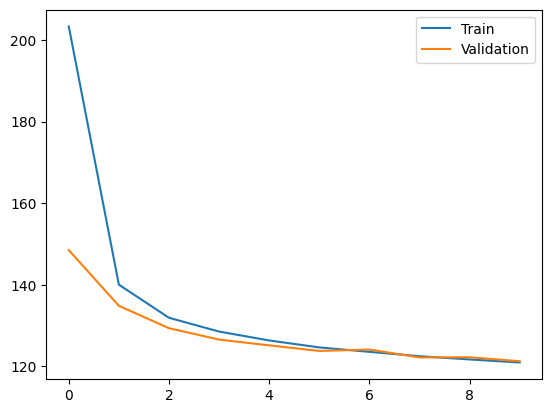

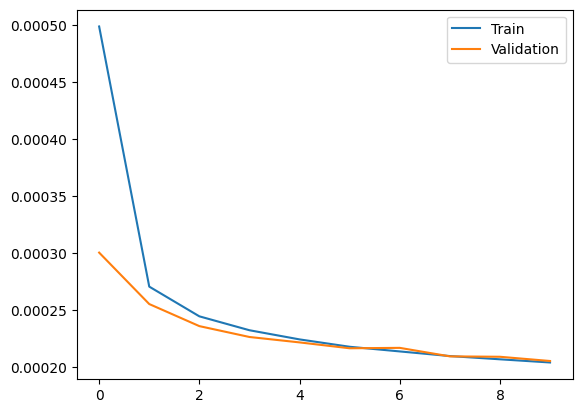

In [30]:
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()
# Plot mses
plt.plot(train_mses, label='Train')
plt.plot(val_mses, label='Validation')
plt.legend()
plt.show()

In [13]:
images = model.sample(10, device)
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

AttributeError: 'VAE' object has no attribute 'sample'

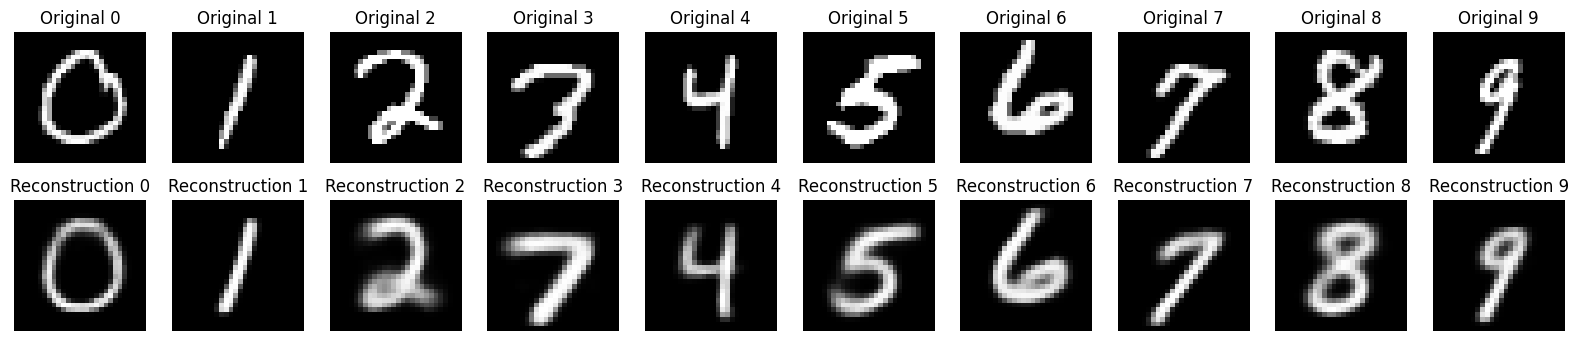

In [31]:
# Collect 1 image per class
images = {}
while len(images) < 10:
    idx = torch.randint(0, len(test_set), (1,)).item()
    x, y = test_set[idx]
    if y not in images:
        images[y.item()] = x

# Reconstruct images
reconstructions = {}
for y, x in images.items():
    x_hat, _, _ = model(x.unsqueeze(0))
    reconstructions[y] = F.sigmoid(x_hat.squeeze(0))

# Plot images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].cpu().detach().numpy().squeeze(), cmap='gray')
    axs[0, i].set_title(f'Original {i}')
    axs[1, i].set_title(f'Reconstruction {i}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()

In [36]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(Z_DIM, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            mu, _ = model.encode(x)
            pred = classifier(mu.detach())
            loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            mu, _ = model.encode(x)
            pred = classifier(mu.detach())
            loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [37]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, EPOCHS, BATCH_SIZE)

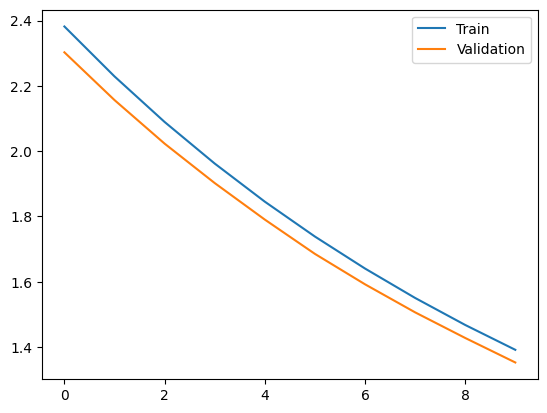

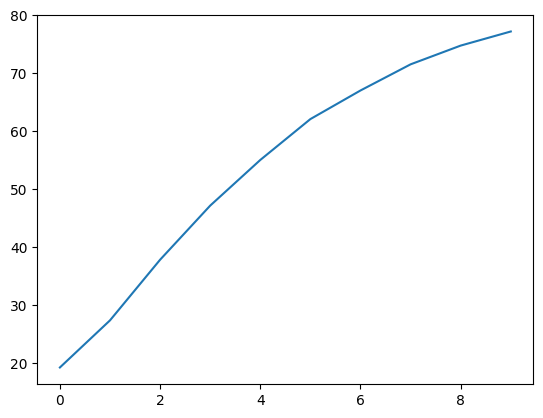

In [34]:
# Plotting

plt.plot(c_t_losses, label='Train')
plt.plot(c_v_losses, label='Validation')
plt.legend()
plt.show()

plt.plot(c_v_accs)
plt.show()
